# Competitors

30 June, 2024

@roman

Code to find neighbors of a given competitor for each property.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm import tqdm
import h3
import os

from scipy.spatial import KDTree
import scipy.sparse as sp
from scipy import io
from sklearn.cluster import MiniBatchKMeans, SpectralClustering, HDBSCAN
from INEGIpy import MarcoGeoestadistico

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# cluster for trails
CLUSTERS_TRIALS = [7, 19, 10] # qro, cancun, cdmx

# subset
gdf_properties = gdf_properties[gdf_properties['city_cluster'].isin(CLUSTERS_TRIALS)]

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 371848 entries, 50 to 1909958
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   half_bathrooms                      371848 non-null  uint8         
 1   full_bathrooms                      371848 non-null  uint8         
 2   property_class_more_common_in_area  371848 non-null  string        
 3   neighborhood                        371847 non-null  string        
 4   constructor                         371644 non-null  string        
 5   zip_code                            371848 non-null  uint32        
 6   age_in_months                       371848 non-null  uint8         
 7   parking_lots                        371848 non-null  uint8         
 8   valuation_date                      371848 non-null  datetime64[ns]
 9   potable_water_service_id            246360 non-null  float64       
 10  lig

In [ ]:
# print observation_id unique
print(gdf_properties['observation_id'].nunique())
print(gdf_properties['observation_id'].nunique())

361545
371848


## Cities

In [5]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/cities.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

# look
gdf_cities

,geometry,cluster,total_properties
0,"POLYGON ((3766192.137 1038920.719, 3766072.241...",0,49294
1,"POLYGON ((2106201.674 1838908.292, 2106105.496...",1,41078
2,"POLYGON ((2083964.935 2167068.796, 2083854.591...",2,49914
3,"POLYGON ((3695976.760 913468.113, 3695883.500 ...",3,4945
4,"POLYGON ((2691489.214 1478562.321, 2691414.834...",4,224732
...,...,...,...
109,"POLYGON ((2809075.793 1188762.402, 2808986.206...",109,1570
110,"POLYGON ((2652237.387 1032197.642, 2652132.900...",110,1158
111,"POLYGON ((2608508.314 1013348.771, 2608407.574...",111,1402
112,"POLYGON ((2401691.811 1520986.348, 2401617.754...",112,1189


In [6]:
# see map
gdf_cities.explore(tiles="cartodbpositron")

## Wrangle

In [7]:
# wrangle
gdf_properties = (
    gdf_properties
    # new vars
    .assign(
        property_type=lambda x: np.where(x['property_type_id'].le(3), 'house', 'apartment'),
        longitude=lambda x: x["geometry"].x,
        latitude=lambda x: x["geometry"].y,
        parking_lots=lambda x: x["parking_lots"].fillna(0),
        price_per_sqm=lambda x: x["price"] / x["saleable_area"],
        log_price_per_sqm=lambda x: np.log(x["price_per_sqm"]),
    )
    .reset_index(drop=True)
    # categorize variables for comparisson
    .assign(
        bedrooms_cat=lambda x: np.select(
            [
                x["bedrooms"].le(1),
                x["bedrooms"].le(2),
                x["bedrooms"].le(3),
                x["bedrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        full_bathrooms_cat=lambda x: np.select(
            [
                x["full_bathrooms"].le(1),
                x["full_bathrooms"].le(2),
                x["full_bathrooms"].le(3),
                x["full_bathrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        half_bathrooms_cat=lambda x: np.select(
            [
                x["half_bathrooms"].le(1),
                x["half_bathrooms"].le(2),
                x["half_bathrooms"].le(3),
                x["half_bathrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        property_class_id_cat=lambda x: np.select(
            [
                x["property_class_id"].le(3),
                x["property_class_id"].le(4),
                x["property_class_id"].gt(4),
            ],
            [
                1, 2, 3
            ],
            default=0
        ),
        conservation_status_id_recat=lambda x: x["conservation_status_id"].replace({7: 4.5}),
        max_total_levels=lambda x:
            x[['level', 'total_levels']].max(axis=1),
        max_total_levels_recat=lambda x: np.select(
            [
                x["max_total_levels"].le(1),
                x["max_total_levels"].le(5),
                x["max_total_levels"].le(15),
                x["max_total_levels"].gt(15),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        elevator_service_id_cat=lambda x:
            np.where(x['elevator_service_id'].eq(1), 1, 0),
        parking_lots_cat=lambda x: np.select(
            [
                x["parking_lots"].le(0),
                x["parking_lots"].le(1),
                x["parking_lots"].le(2),
                x["parking_lots"].gt(2),
            ],
            [
                0, 1, 2, 3
            ],
            default=0
        ),
    )
)   

## Mini EDA

In [8]:
# see cat vars description
(
    gdf_properties
    .filter(like="_cat")
    .apply(pd.Series.value_counts)
    .div(gdf_properties.shape[0])
)

,bedrooms_cat,full_bathrooms_cat,half_bathrooms_cat,property_class_id_cat,elevator_service_id_cat,parking_lots_cat
0,NaN,NaN,NaN,NaN,0.924367,0.172372
1,0.053863,0.575988,0.984432,0.389829,0.075633,0.576620
2,0.568673,0.296264,0.013562,0.476243,NaN,0.215706
3,0.324998,0.086573,0.001659,0.133928,NaN,0.035302
4,0.052465,0.041175,0.000347,NaN,NaN,NaN


In [9]:
# see how many properties didnt join
gdf_properties["city_cluster"].isna().sum()

0

In [10]:
# if there is a index repeated
gdf_properties.index.duplicated().sum()

0

---
# Get Competitors

## S1: Calculate

In [ ]:
# functions
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())


def get_neighbors_properties(gdf, r=1):
    # copy
    gdf = gdf.copy()

    # fit kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )

    # get neighbors at r-km
    return kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1
    )


def get_possible_neighbors(df_own, df_theirs, vars_list):
    # Select only relevant columns and explode neighbors_list column in df_own
    df_own_expanded = (
        df_own
        .loc[:, vars_list + ['neighbors_list']]
        .explode('neighbors_list')  # Expands neighbors_list into multiple rows
        .rename(columns={'neighbors_list': 'id_neighbor'})  # Rename for merge clarity
        .reset_index()  # Reset index to use in merging
    )

    # Prepare df_theirs for merging by keeping track of original indexes
    df_theirs_indexed = (
        df_theirs
        .assign(index=lambda x: x.index)  # Add index column for merging
        .loc[:, ['index'] + vars_list]  # Select only relevant columns
    )

    # Merge expanded df_own with df_theirs based on neighbor IDs
    merged_df = df_own_expanded.merge(
        df_theirs_indexed,
        how='inner',
        left_on='id_neighbor',  # Match on the id_neighbor column from df_own
        right_on='index',  # Match on index from df_theirs
        suffixes=('_own', '_neighbor')
    )

    # Filter out rows where observation_id_own is the same as observation_id_neighbor
    result_df = merged_df.query("observation_id_own != observation_id_neighbor", engine='python')
    
    return result_df


# get distance
def distance_of_competitors(gdf):
    # Step 1: Distance
    return (
        gdf.copy()
        # helpers
        .assign(
            # time distance
            time_distance=lambda x: np.sqrt(
                ((x['valuation_date_own'] - x['valuation_date_neighbor']).dt.days / (365 * 2))**2
            ),
            land_area_proportion=lambda x: x['land_area_neighbor'] / x['land_area_own'],
            built_area_proportion=lambda x: x['built_area_neighbor'] / x['built_area_own'],
        )
        # filter
        .query("time_distance.le(1) & land_area_proportion.between(0.5, 2) & built_area_proportion.between(0.25, 4)")        
        .drop(columns=['time_distance', 'land_area_proportion', 'built_area_proportion'])
        # distances: TODO: Check distributions
        .assign(
            # geo distance
            geo_distance=lambda x: np.sqrt(
                (x['longitude_own'] - x['longitude_neighbor'])**2
                + (x['latitude_own'] - x['latitude_neighbor'])**2
            ),
            # topology distance
            terrain_distance=lambda x: np.sqrt(
                (x['land_area_neighbor'] - x['land_area_own'])**2
            ),
            built_distance=lambda x: np.sqrt(
                (x['built_area_neighbor'] - x['built_area_own'])**2
            ),
            # conservation
            conservation_distance=lambda x: np.sqrt(
                (x['age_in_months_own'] - x['age_in_months_neighbor'])**2
                + (x['conservation_status_id_recat_own'] - x['conservation_status_id_recat_neighbor'])**2
            ),
            # characteristics distance
            characteristics_distance=lambda x: np.sqrt(
                (x['elevator_service_id_cat_own'] - x['elevator_service_id_cat_neighbor'])**2
                + (x['max_total_levels_recat_own'] - x['max_total_levels_recat_neighbor'])**2
                + (x['bedrooms_cat_own'] - x['bedrooms_cat_neighbor'])**2
                + (x['full_bathrooms_cat_own'] - x['full_bathrooms_cat_neighbor'])**2
                + (x['half_bathrooms_cat_own'] - x['half_bathrooms_cat_neighbor'])**2
                + (x['parking_lots_cat_own'] - x['parking_lots_cat_neighbor'])**2
                + (x['property_class_id_cat_own'] - x['property_class_id_cat_neighbor'])**2
            ),
            # time distance
            time_distance=lambda x: np.sqrt(
                # TODO: think in months
                ((x['valuation_date_own'] - x['valuation_date_neighbor']).dt.days / (365 * 2))**2
            ),
        )
        # normalize distances
        .assign(
            geo_distance_norm=lambda x: min_max(x['geo_distance']),
            terrain_distance_norm=lambda x: min_max(x['terrain_distance']),
            built_distance_norm=lambda x: min_max(x['built_distance']),
            conservation_distance_norm=lambda x: min_max(x['conservation_distance']),
            characteristics_distance_norm=lambda x: min_max(x['characteristics_distance']),
            time_distance_norm=lambda x: min_max(x['time_distance'])
        )
        # total distance
        .assign(
            total_distance=lambda x: min_max(
                x['geo_distance_norm'] * GEO_WEIGHT
                + x['terrain_distance_norm'] * TERRAIN_WEIGHT
                + x['built_distance_norm'] * BUILT_WEIGHT
                + x['conservation_distance_norm'] * CONSERVATION_WEIGHT
                + x['characteristics_distance_norm'] * CHAR_WEIGHT
                + x['time_distance_norm'] * TIME_WEIGHT
            )
        )
        # eliminate 0s in the distance to avoid comparing to itself
        .query("total_distance.gt(0)")
        .reset_index(drop=True)
    )


# find competitors
def subset_competitors(gdf):
    # Aggregation
    return (
        gdf
        .assign(
            index_distance_tuple=lambda x: list(zip(x['observation_id_neighbor'], x['total_distance'])),
        )
        .groupby('observation_id_own', as_index=False)
        .agg(
            neighbors_list=('index_distance_tuple', list),
            num_neighbors=('observation_id_neighbor', 'count'),
        )
    )


# function to orchestrate the process
def get_competitors(gdf, cols_to_stay, property_type='apartment', city=0, batch_size=None, radius=1):
    # subset 
    gdf_work = (
        gdf
        .query("city_cluster.eq(@city) & property_type.eq(@property_type)", engine='python')
        .reset_index(drop=True)
        .copy()
    )

    # check if there are properties
    if gdf_work.shape[0] == 0:
        print("No properties to compare")
        return pd.DataFrame()

    # get neighbors
    gdf_work['neighbors_list'] = get_neighbors_properties(gdf_work, r=radius)

    # get possible neighbors by batch
    n_batches = gdf_work.shape[0] // batch_size
    if n_batches > 0:
        batch_indexes = np.array_split(gdf_work.index, gdf_work.shape[0] // batch_size)
    else:
        batch_indexes = [gdf_work.index]

    gdf_neighbors_list = []
    for batch in batch_indexes:
        # get possible neighbors
        gdf_neighbors_info = get_possible_neighbors(
            df_own=gdf_work.loc[batch],
            df_theirs=gdf_work,
            vars_list=cols_to_stay
        )
        # find competitors & append
        gdf_neighbors_list.append(
                subset_competitors(distance_of_competitors(gdf_neighbors_info))
            )

    # concatenate
    gdf_neighbors = pd.concat(gdf_neighbors_list)
    
    return gdf_neighbors

### Manually

In [78]:
# PARAMS
# params
GEO_WEIGHT = 0.3
TERRAIN_WEIGHT = 0.1
CONSERVATION_WEIGHT = 0.15
BUILT_WEIGHT = 0.20
CHAR_WEIGHT = 0.15
TIME_WEIGHT = 0.1

# gdf
gdf2 = gdf_properties.copy()
property_type_comps = 'apartment'
city_comps = 19
batch_size_comps = 2_000
radius_comps = 2.5

In [144]:
gdf_properties.loc[:, cols_to_stay_comps]

,observation_id,longitude,latitude,land_area,built_area,elevator_service_id_cat,max_total_levels_recat,age_in_months,bedrooms_cat,full_bathrooms_cat,parking_lots_cat,half_bathrooms_cat,property_class_id_cat,conservation_status_id_recat,valuation_date
0,5b5a968f-0cdb-44bc-b91d-f53139b06dad,2.666478e+06,963477.808403,278.940002,230.320007,0,2,4,3,4,2,1,3,3.0,2022-05-11
1,a669e55e-b86c-4e75-97f7-e440134bdfa7,2.674386e+06,964895.379272,120.279999,110.279999,0,2,2,3,2,0,1,2,4.0,2022-05-05
2,c65408f6-894d-4f60-a9bb-289bbdf8a1f8,2.783638e+06,822412.136257,70.000000,88.419998,0,2,192,3,2,2,1,2,4.0,2022-05-12
3,76f72ed1-05e5-4ec4-852b-7e0ee0c3bd0d,2.657112e+06,956243.251920,174.339996,56.770000,0,2,96,2,1,0,1,1,4.0,2022-11-23
4,179f0fb2-3450-43d1-89af-9226c8224328,2.657358e+06,956717.953807,74.250000,61.430000,0,2,96,2,1,1,1,1,4.0,2022-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371843,2791d789-6f7a-46c0-856c-aad90796b82f,2.803483e+06,872190.607727,52.650002,42.450001,0,2,0,2,1,1,1,1,6.0,2022-11-24
371844,6b8532e5-319d-4b58-90f3-8c656145fd54,2.803483e+06,872190.607727,61.430000,42.349998,0,2,0,2,1,1,1,1,6.0,2022-11-23
371845,96b1bc4a-8c77-43cf-8328-3c9323f5268d,2.803483e+06,872190.607727,52.650002,42.669998,0,2,0,2,1,1,1,1,6.0,2022-11-24
371846,215a1fce-1e4a-40df-90ac-bfce26fc3eb0,2.803483e+06,872190.607727,55.349998,42.630001,0,2,0,2,1,1,1,1,6.0,2022-11-24


In [79]:
# S1: Subset
cols_to_stay_comps = [
    # variables to stay
    'observation_id',
    # geographic
    'longitude', 'latitude',
    # topology
    'land_area', 'built_area',
    # characteristics
    'elevator_service_id_cat', 'max_total_levels_recat', 'age_in_months', 
    'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat', 'half_bathrooms_cat',
    'property_class_id_cat', 'conservation_status_id_recat',
    # time
    'valuation_date'
]

gdf_work_comps = (
    gdf2
    .query("city_cluster.eq(@city_comps) & property_type.eq(@property_type_comps)", engine='python')
    .reset_index(drop=True)
    .copy()
)

# see
print(gdf_work_comps.shape)
gdf_work_comps

(16703, 66)


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,geometry,property_type,price_per_sqm,log_price_per_sqm,bedrooms_cat,full_bathrooms_cat,half_bathrooms_cat,property_class_id_cat,conservation_status_id_recat,max_total_levels,max_total_levels_recat,elevator_service_id_cat,parking_lots_cat
0,0,1,3,SUPERMANZANA 260,NO APLICA,77539,3,1,2022-06-28,NaN,NaN,NaN,NaN,3,4,d0b0893f-1303-4772-a40f-1d218bc28a3f,0.0,23,1,NaN,3,6,005,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,6a9c3931-ae31-4d41-8403-a0098c9e9d38,1.096969e+06,4.054681e+06,4,1,S/D,3,66.330002,66.330002,57.580002,1.0,NaN,<NA>,1009542.0,1010000.0,573944.01,160648.200000,<NA>,60,198ccd40-3da5-48a1-bd30-9f7fbb16e586,5d529c04-e7a1-524e-829b-e60bce5f3afd,19,POINT (4054681.196 1096968.723),apartment,15226.895404,9.630819,3,1,1,1,4.0,4,2,0,1
1,1,2,4,SUPERMANZANA 333,ALTTA HOMES,77536,0,1,2022-11-24,NaN,NaN,NaN,NaN,4,6,754cdf00-e8eb-4815-a8cc-4267ec7bca6d,0.0,23,3,NaN,3,2,005,7bc546d9-fc16-4791-b0e0-e378fc472b6d,2,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,8a78129e-0390-4ee2-9ad2-c984f11ce82e,1.093091e+06,4.060021e+06,5,1,S/D,3,92.110001,92.110001,77.620003,1.0,NaN,<NA>,2080877.0,2081000.0,1155888.17,302718.000000,<NA>,70,c40a57b7-b345-46ae-be6e-981ea0fe7976,fae68317-5a75-56b8-8ad3-68905c656c8f,19,POINT (4060021.332 1093090.823),apartment,22592.552233,10.025376,3,2,1,2,6.0,5,2,0,1
2,0,2,3,SUPERMANZANA 249,NO APLICA,77518,0,1,2022-06-19,NaN,NaN,NaN,NaN,3,6,754cdf00-e8eb-4815-a8cc-4267ec7bca6d,0.0,23,3,NaN,3,6,005,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,6a9c3931-ae31-4d41-8403-a0098c9e9d38,1.101878e+06,4.059133e+06,3,1,S/D,3,78.000000,78.000000,28.719999,60.0,NaN,<NA>,1079520.0,1080000.0,702000.00,83575.200000,<NA>,60,8d99ec80-2693-4fa5-9a22-e43bcbb39979,c2d0b0bf-ebd0-5b23-abff-49e806775733,19,POINT (4059132.617 1101877.547),apartment,13846.153846,9.535763,3,2,1,1,6.0,3,2,0,1
3,0,2,3,SUPERMANZANA 319,NO APLICA,77536,0,1,2022-11-03,NaN,NaN,NaN,NaN,3,6,754cdf00-e8eb-4815-a8cc-4267ec7bca6d,0.0,23,3,NaN,3,6,005,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,6a9c3931-ae31-4d41-8403-a0098c9e9d38,1.094456e+06,4.059308e+06,4,1,S/D,3,73.440002,73.440002,85.470001,120.0,NaN,<NA>,2023272.0,2023000.0,1282629.59,413674.800000,<NA>,60,d3a13b0b-ac17-44b7-8991-7b41600644cf,d6a3acec-f912-59e1-b039-d40583502460,19,POINT (4059308.325 1094455.547),apartment,27546.295381,10.223623,3,2,1,1,6.0,4,2,0,1
4,0,2,4,SUPERMANZANA 319,NO APLICA,77536,0,1,2022-11-09,NaN,NaN,NaN,NaN,4,6,754cdf00-e8eb-4815-a8cc-4267ec7bca6d,0.0,23,3,NaN,3,2,005,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,6a9c3931-ae31-4d41-8403-a0098c9e9d38,1.094648e+06,4.059663e+06,3,1,S/D,3,76.809998,76.809998,31.379999,150.0,NaN,<NA>,2000900.0,2001000.0,1382580.00,151565.400000,<NA>,70,0b106346-f1e1-492d-a4bf-85a5ced366c8,ece54a5c-daa2-5eaf-9e76-c1d72eb30d08,19,POINT (4059663.175 1094647.893),apartment,26051.296232,10.167823,3,2,1,2,6.0,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [81]:
# S2: get neighbors
gdf_work_comps['neighbors_list'] = get_neighbors_properties(gdf_work_comps, r=radius_comps)

In [82]:
# see gdf work
gdf_work_comps.index

RangeIndex(start=0, stop=16703, step=1)

In [83]:
# length nieghbors_list
gdf_work_comps.iloc[0, -1]

[0,
 28,
 29,
 30,
 32,
 33,
 43,
 58,
 97,
 103,
 105,
 107,
 108,
 110,
 111,
 112,
 113,
 116,
 117,
 118,
 119,
 121,
 123,
 126,
 127,
 128,
 130,
 137,
 141,
 142,
 143,
 144,
 146,
 147,
 148,
 149,
 174,
 179,
 180,
 181,
 197,
 216,
 218,
 220,
 229,
 284,
 285,
 333,
 334,
 335,
 336,
 338,
 343,
 390,
 391,
 392,
 393,
 399,
 410,
 413,
 414,
 415,
 416,
 417,
 420,
 422,
 426,
 427,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 509,
 512,
 517,
 519,
 522,
 547,
 548,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 560,
 561,
 563,
 566,
 569,
 571,
 572,
 573,
 579,
 584,
 586,
 592,
 593,
 622,
 625,
 627,
 628,
 629,
 631,
 632,
 633,
 663,
 664,
 665,
 666,
 667,
 673,
 677,
 678,
 679,
 681,
 683,
 684,
 685,
 714,
 715,
 717,
 718,
 719,
 720,
 721,
 735,
 736,
 737,
 738,
 740,
 752,
 807,
 808,
 810,
 812,
 814,
 815,
 817,
 829,
 830,
 832,
 833,
 834,
 835,
 839,
 840,
 841,
 842,
 843,
 844,
 845,
 846,
 847,
 8

In [84]:
# len
len(gdf_work_comps.iloc[0, -1])

4582

#### Neighbor search

##### One by One

In [85]:
# see
gdf_work_comps.head(2)

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,geometry,property_type,price_per_sqm,log_price_per_sqm,bedrooms_cat,full_bathrooms_cat,half_bathrooms_cat,property_class_id_cat,conservation_status_id_recat,max_total_levels,max_total_levels_recat,elevator_service_id_cat,parking_lots_cat,neighbors_list
0,0,1,3,SUPERMANZANA 260,NO APLICA,77539,3,1,2022-06-28,NaN,NaN,NaN,NaN,3,4,d0b0893f-1303-4772-a40f-1d218bc28a3f,0.0,23,1,NaN,3,6,005,7bc546d9-fc16-4791-b0e0-e378fc472b6d,3,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,6a9c3931-ae31-4d41-8403-a0098c9e9d38,1.096969e+06,4.054681e+06,4,1,S/D,3,66.330002,66.330002,57.580002,1.0,NaN,<NA>,1009542.0,1010000.0,573944.01,160648.2,<NA>,60,198ccd40-3da5-48a1-bd30-9f7fbb16e586,5d529c04-e7a1-524e-829b-e60bce5f3afd,19,POINT (4054681.196 1096968.723),apartment,15226.895404,9.630819,3,1,1,1,4.0,4,2,0,1,"[0, 28, 29, 30, 32, 33, 43, 58, 97, 103, 105, ..."
1,1,2,4,SUPERMANZANA 333,ALTTA HOMES,77536,0,1,2022-11-24,NaN,NaN,NaN,NaN,4,6,754cdf00-e8eb-4815-a8cc-4267ec7bca6d,0.0,23,3,NaN,3,2,005,7bc546d9-fc16-4791-b0e0-e378fc472b6d,2,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,8a78129e-0390-4ee2-9ad2-c984f11ce82e,1.093091e+06,4.060021e+06,5,1,S/D,3,92.110001,92.110001,77.620003,1.0,NaN,<NA>,2080877.0,2081000.0,1155888.17,302718.0,<NA>,70,c40a57b7-b345-46ae-be6e-981ea0fe7976,fae68317-5a75-56b8-8ad3-68905c656c8f,19,POINT (4060021.332 1093090.823),apartment,22592.552233,10.025376,3,2,1,2,6.0,5,2,0,1,"[1, 3, 4, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18..."


In [107]:
# select 1 index
idx_test = gdf_work_comps.query("neighborhood.str.contains('SUPERMANZANA', case=False, na=False)", engine='python').index[0]

# get neighbors
gdf_neighbors_info = get_possible_neighbors(
    df_own=gdf_work_comps.loc[[idx_test], :],
    df_theirs=gdf_work_comps,
    vars_list=cols_to_stay_comps
)

# see neighbors
gdf_neighbors_info

,index_own,observation_id_own,longitude_own,latitude_own,land_area_own,built_area_own,elevator_service_id_cat_own,max_total_levels_recat_own,age_in_months_own,bedrooms_cat_own,full_bathrooms_cat_own,parking_lots_cat_own,half_bathrooms_cat_own,property_class_id_cat_own,conservation_status_id_recat_own,valuation_date_own,id_neighbor,index_neighbor,observation_id_neighbor,longitude_neighbor,latitude_neighbor,land_area_neighbor,built_area_neighbor,elevator_service_id_cat_neighbor,max_total_levels_recat_neighbor,age_in_months_neighbor,bedrooms_cat_neighbor,full_bathrooms_cat_neighbor,parking_lots_cat_neighbor,half_bathrooms_cat_neighbor,property_class_id_cat_neighbor,conservation_status_id_recat_neighbor,valuation_date_neighbor
1,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,28,28,45044e49-a7b4-4262-8b9d-d617c4f4b94b,4.055081e+06,1.095898e+06,39.570000,50.869999,0,2,0,2,1,1,1,1,6.0,2022-06-06
2,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,29,29,77ab9953-629a-4aa0-95be-783d2f81a7e6,4.054791e+06,1.098566e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06
3,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,30,30,8e893e16-b0e8-4763-bac8-02fd34547cac,4.054775e+06,1.098580e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06
4,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,32,32,e69a03bb-aadf-4ca0-a080-96470213f1df,4.054806e+06,1.098589e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06
5,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,33,33,93a8dcc0-7562-418a-9ac5-9a141430882b,4.054810e+06,1.098595e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16656,16656,e47318f1-dd6c-4d1e-b651-ffe7ce7d5b4a,4.055343e+06,1.096265e+06,40.490002,50.869999,0,2,0,2,1,1,1,1,6.0,2019-10-23
4578,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16658,16658,75da43dd-6e80-44dc-a4bb-f33d458d72c4,4.055095e+06,1.096044e+06,45.279999,47.720001,0,3,0,2,1,1,1,1,6.0,2020-03-04
4579,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16668,16668,63f57b16-f4cb-47df-a06c-dcf66a12fa93,4.055086e+06,1.095988e+06,39.910000,50.869999,0,2,0,2,1,1,1,1,6.0,2021-08-24
4580,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16669,16669,f38e340a-25ca-4fc4-871d-515198ded3ca,4.055112e+06,1.095925e+06,37.070000,47.720001,0,3,0,2,1,1,1,1,6.0,2021-12-16


In [108]:
# get distance
gdf_neighbors_subset_distance = distance_of_competitors(gdf_neighbors_info)

# see   
gdf_neighbors_subset_distance

,index_own,observation_id_own,longitude_own,latitude_own,land_area_own,built_area_own,elevator_service_id_cat_own,max_total_levels_recat_own,age_in_months_own,bedrooms_cat_own,full_bathrooms_cat_own,parking_lots_cat_own,half_bathrooms_cat_own,property_class_id_cat_own,conservation_status_id_recat_own,valuation_date_own,id_neighbor,index_neighbor,observation_id_neighbor,longitude_neighbor,latitude_neighbor,land_area_neighbor,built_area_neighbor,elevator_service_id_cat_neighbor,max_total_levels_recat_neighbor,age_in_months_neighbor,bedrooms_cat_neighbor,full_bathrooms_cat_neighbor,parking_lots_cat_neighbor,half_bathrooms_cat_neighbor,property_class_id_cat_neighbor,conservation_status_id_recat_neighbor,valuation_date_neighbor,geo_distance,terrain_distance,built_distance,conservation_distance,characteristics_distance,time_distance,geo_distance_norm,terrain_distance_norm,built_distance_norm,conservation_distance_norm,characteristics_distance_norm,time_distance_norm,total_distance
0,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,28,28,45044e49-a7b4-4262-8b9d-d617c4f4b94b,4.055081e+06,1.095898e+06,39.570000,50.869999,0,2,0,2,1,1,1,1,6.0,2022-06-06,1143.262516,18.010002,15.460003,3.605551,1.000000,0.030137,0.458299,0.329552,0.459982,0.234206,0.447214,0.030345,0.367689
1,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,29,29,77ab9953-629a-4aa0-95be-783d2f81a7e6,4.054791e+06,1.098566e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1600.897498,11.040001,21.240002,3.605551,1.732051,0.072603,0.646897,0.202013,0.631955,0.234206,0.774597,0.073103,0.499292
2,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,30,30,8e893e16-b0e8-4763-bac8-02fd34547cac,4.054775e+06,1.098580e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1613.578072,11.040001,21.240002,3.605551,1.732051,0.072603,0.652123,0.202013,0.631955,0.234206,0.774597,0.073103,0.500860
3,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,32,32,e69a03bb-aadf-4ca0-a080-96470213f1df,4.054806e+06,1.098589e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1624.637474,11.040001,21.240002,3.605551,1.732051,0.072603,0.656681,0.202013,0.631955,0.234206,0.774597,0.073103,0.502227
4,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,33,33,93a8dcc0-7562-418a-9ac5-9a141430882b,4.054810e+06,1.098595e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1631.789908,11.040001,21.240002,3.605551,1.732051,0.072603,0.659628,0.202013,0.631955,0.234206,0.774597,0.073103,0.503111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16640,16640,877fa6c5-882f-4ba2-a375-7893f31b22b9,4.055101e+06,1.098834e+06,46.980000,53.639999,0,2,48,2,1,1,1,1,4.0,2022-08-10,1911.750323,10.600002,12.690002,15.264338,1.000000,0.058904,0.775004,0.193962,0.377566,0.991525,0.447214,0.059310,0.549153
2716,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16643,16643,cdd75136-d720-4284-b688-3a32fea4a016,4.055690e+06,1.095086e+06,40.130001,50.869999,0,2,0,2,1,1,1,1,6.0,2023-06-23,2135.675183,17.450001,15.460003,3.605551,1.000000,0.493151,0.867287,0.319305,0.459982,0.234206,0.447214,0.496552,0.535981
2717,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16654,16654,f32a8dc3-ea3d-48c4-b2e1-7aae62946745,4.055194e+06,1.095718e+06,36.040001,47.720001,0,3,0,2,1,1,1,1,6.0,2021-02-11,1351.713985,21.540001,18.610001,3.6

In [109]:
gdf_work_comps.loc[[idx_test], ['observation_id', 'price_per_sqm']]

,observation_id,price_per_sqm
0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,15226.895404


array([[<Axes: title={'center': 'geo_distance'}>,
        <Axes: title={'center': 'terrain_distance'}>,
        <Axes: title={'center': 'built_distance'}>,
        <Axes: title={'center': 'conservation_distance'}>],
       [<Axes: title={'center': 'characteristics_distance'}>,
        <Axes: title={'center': 'time_distance'}>,
        <Axes: title={'center': 'geo_distance_norm'}>,
        <Axes: title={'center': 'terrain_distance_norm'}>],
       [<Axes: title={'center': 'built_distance_norm'}>,
        <Axes: title={'center': 'conservation_distance_norm'}>,
        <Axes: title={'center': 'characteristics_distance_norm'}>,
        <Axes: title={'center': 'time_distance_norm'}>],
       [<Axes: title={'center': 'total_distance'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

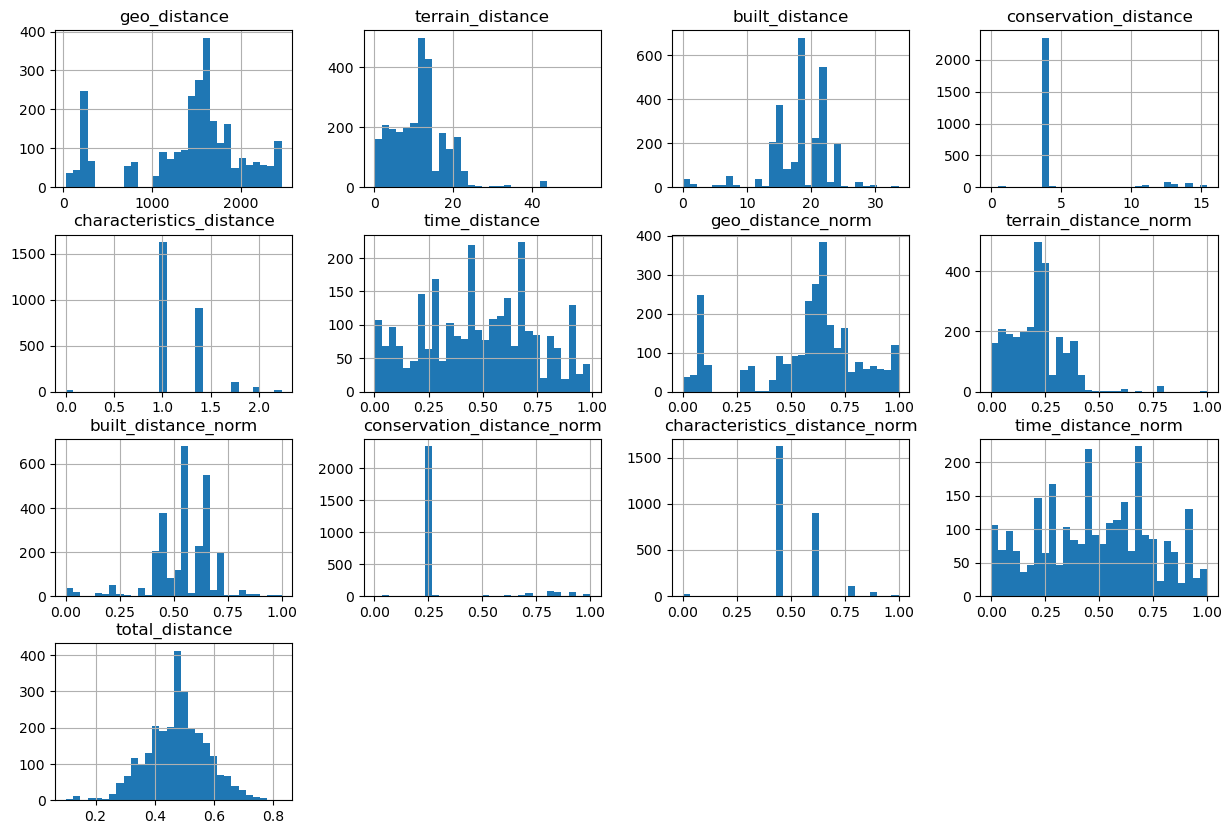

In [110]:
# see distribution of distances
gdf_neighbors_subset_distance.filter(like='distance').hist(bins=30, figsize=(15, 10))

In [111]:
# Step 1: Plot the main property
m = gdf_work_comps.loc[[idx_test], ['longitude', 'latitude', 'geometry']].explore(
    tiles="cartodbpositron",
    color="red",  # Use a distinct color for main property
    marker_kwds={'radius': 10},  # Adjust marker size if needed
    # tooltip="Main Property"  # Add a tooltip for easy identification
)

# Step 2: Add neighbors as a separate layer
neighbor_layer = (
    gdf_neighbors_subset_distance
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .loc[:, ['total_distance','geometry']]
    .explore(
        m=m,  # Add to the existing map
        color="blue",  # Different color for neighbors
        marker_kwds={'radius': 3},  # Adjust marker size if needed
        # tooltip="Competitor"
    )
)

# Display map
m

In [112]:
# Step 1: Plot the main property
m = gdf_work_comps.loc[[idx_test], ['longitude', 'latitude', 'geometry']].explore(
    tiles="cartodbpositron",
    color="red",  # Use a distinct color for main property
    marker_kwds={'radius': 20},  # Adjust marker size if needed
    # tooltip="Main Property"  # Add a tooltip for easy identification
)

# Step 2: Add neighbors as a separate layer
neighbor_layer = (
    gdf_neighbors_subset_distance
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .loc[:, ['total_distance','geometry']]
    .explore(
        'total_distance',
        m=m,  # Add to the existing map
        marker_kwds={'radius': 5},  # Adjust marker size if needed
        # tooltip="Competitor"
    )
)

# Display map
m

In [113]:
gdf_neighbors_subset_distance

,index_own,observation_id_own,longitude_own,latitude_own,land_area_own,built_area_own,elevator_service_id_cat_own,max_total_levels_recat_own,age_in_months_own,bedrooms_cat_own,full_bathrooms_cat_own,parking_lots_cat_own,half_bathrooms_cat_own,property_class_id_cat_own,conservation_status_id_recat_own,valuation_date_own,id_neighbor,index_neighbor,observation_id_neighbor,longitude_neighbor,latitude_neighbor,land_area_neighbor,built_area_neighbor,elevator_service_id_cat_neighbor,max_total_levels_recat_neighbor,age_in_months_neighbor,bedrooms_cat_neighbor,full_bathrooms_cat_neighbor,parking_lots_cat_neighbor,half_bathrooms_cat_neighbor,property_class_id_cat_neighbor,conservation_status_id_recat_neighbor,valuation_date_neighbor,geo_distance,terrain_distance,built_distance,conservation_distance,characteristics_distance,time_distance,geo_distance_norm,terrain_distance_norm,built_distance_norm,conservation_distance_norm,characteristics_distance_norm,time_distance_norm,total_distance
0,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,28,28,45044e49-a7b4-4262-8b9d-d617c4f4b94b,4.055081e+06,1.095898e+06,39.570000,50.869999,0,2,0,2,1,1,1,1,6.0,2022-06-06,1143.262516,18.010002,15.460003,3.605551,1.000000,0.030137,0.458299,0.329552,0.459982,0.234206,0.447214,0.030345,0.367689
1,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,29,29,77ab9953-629a-4aa0-95be-783d2f81a7e6,4.054791e+06,1.098566e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1600.897498,11.040001,21.240002,3.605551,1.732051,0.072603,0.646897,0.202013,0.631955,0.234206,0.774597,0.073103,0.499292
2,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,30,30,8e893e16-b0e8-4763-bac8-02fd34547cac,4.054775e+06,1.098580e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1613.578072,11.040001,21.240002,3.605551,1.732051,0.072603,0.652123,0.202013,0.631955,0.234206,0.774597,0.073103,0.500860
3,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,32,32,e69a03bb-aadf-4ca0-a080-96470213f1df,4.054806e+06,1.098589e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1624.637474,11.040001,21.240002,3.605551,1.732051,0.072603,0.656681,0.202013,0.631955,0.234206,0.774597,0.073103,0.502227
4,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,33,33,93a8dcc0-7562-418a-9ac5-9a141430882b,4.054810e+06,1.098595e+06,46.540001,45.090000,0,3,0,2,1,0,1,1,6.0,2022-05-06,1631.789908,11.040001,21.240002,3.605551,1.732051,0.072603,0.659628,0.202013,0.631955,0.234206,0.774597,0.073103,0.503111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16640,16640,877fa6c5-882f-4ba2-a375-7893f31b22b9,4.055101e+06,1.098834e+06,46.980000,53.639999,0,2,48,2,1,1,1,1,4.0,2022-08-10,1911.750323,10.600002,12.690002,15.264338,1.000000,0.058904,0.775004,0.193962,0.377566,0.991525,0.447214,0.059310,0.549153
2716,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16643,16643,cdd75136-d720-4284-b688-3a32fea4a016,4.055690e+06,1.095086e+06,40.130001,50.869999,0,2,0,2,1,1,1,1,6.0,2023-06-23,2135.675183,17.450001,15.460003,3.605551,1.000000,0.493151,0.867287,0.319305,0.459982,0.234206,0.447214,0.496552,0.535981
2717,0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,4.054681e+06,1.096969e+06,57.580002,66.330002,0,2,3,3,1,1,1,1,4.0,2022-06-28,16654,16654,f32a8dc3-ea3d-48c4-b2e1-7aae62946745,4.055194e+06,1.095718e+06,36.040001,47.720001,0,3,0,2,1,1,1,1,6.0,2021-02-11,1351.713985,21.540001,18.610001,3.6

In [114]:
# top 10 props
# Step 1: Plot the main property
m = (
    gdf_neighbors_subset_distance
    .loc[[0], ['longitude_own', 'latitude_own', 'observation_id_own', 'land_area_own', 'built_area_own', 'age_in_months_own', 'bedrooms_cat_own', 'full_bathrooms_cat_own', 'parking_lots_cat_own']]
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_own'], x['latitude_own'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .merge(
        gdf_work_comps.loc[[idx_test], ['observation_id', 'price_per_sqm']],
        left_on='observation_id_own',
        right_on='observation_id'
    )
    .drop(columns=['longitude_own', 'latitude_own', 'observation_id_own', 'observation_id'])
    .explore(
        tiles="cartodbpositron",
        color="red",  # Use a distinct color for main property
        marker_kwds={'radius': 20},  # Adjust marker size if needed
    )
)

# Step 2: Add neighbors as a separate layer
neighbor_layer = (
    gdf_neighbors_subset_distance
    .merge(
        gdf_work_comps.loc[:, ['observation_id', 'price_per_sqm']],
        left_on='observation_id_neighbor',
        right_on='observation_id'
    )
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude_neighbor'], x['latitude_neighbor'])
    )
    .pipe(gpd.GeoDataFrame, crs="EPSG:6372")
    .loc[:, ['price_per_sqm', 'total_distance', 'geometry', 'longitude_neighbor', 'latitude_neighbor', 'observation_id_neighbor', 'land_area_neighbor', 'built_area_neighbor', 'age_in_months_neighbor', 'bedrooms_cat_neighbor', 'full_bathrooms_cat_neighbor', 'parking_lots_cat_neighbor']]
    .drop(columns=['longitude_neighbor', 'latitude_neighbor', 'observation_id_neighbor'])
    .sort_values('total_distance', ascending=True)
    .head(10)
    .explore(
        'price_per_sqm',
        m=m,  # Add to the existing map
        marker_kwds={'radius': 10},  # Adjust marker size if needed
        # tooltip="Competitor"
    )
)

# Display map
neighbor_layer

In [115]:
# get top 10 competitors
(
    gdf_neighbors_subset_distance
    .merge(
        gdf_work_comps.loc[:, ['observation_id', 'price_per_sqm']],
        left_on='observation_id_neighbor',
        right_on='observation_id'
    )
    .rename(columns={
        'price_per_sqm': 'price_per_sqm_neighbor',
        'total_distance': 'total_distance_neighbor',
        'geo_distance': 'geo_distance_neighbor',
    })
    .sort_values('total_distance_neighbor', ascending=True)
    .head(10)
    .filter(like='neighbor')
    # to all columns eliminate the suffix
    .rename(columns=lambda x: x.replace('_neighbor', ''))
)

,id,index,observation_id,longitude,latitude,land_area,built_area,elevator_service_id_cat,max_total_levels_recat,age_in_months,bedrooms_cat,full_bathrooms_cat,parking_lots_cat,half_bathrooms_cat,property_class_id_cat,conservation_status_id_recat,valuation_date,geo_distance,total_distance,price_per_sqm
214,1020,1020,11f12551-3a2a-4626-a98e-b7371324d069,4.054668e+06,1.096874e+06,58.150002,66.330002,0,2,36,3,1,1,1,1,4.0,2022-09-29,95.223741,0.100342,14427.860298
946,4614,4614,f208a0d2-d6e2-415e-a39b-8659f96e4c17,4.054718e+06,1.096870e+06,58.150002,66.330002,0,2,0,3,1,1,1,1,6.0,2021-02-11,105.653345,0.114621,12181.516323
818,3966,3966,1214c3fc-4a79-4e3a-8fda-1dd98595fc14,4.054660e+06,1.097010e+06,58.919998,58.919998,0,2,0,3,1,1,1,1,6.0,2023-02-22,46.073520,0.116482,23302.784159
1833,8244,8244,5a6c9dc8-4bde-4390-841a-90eeb7f9d9d6,4.054714e+06,1.096874e+06,57.580002,66.330002,0,2,0,3,1,1,1,1,6.0,2020-11-13,99.916290,0.125282,12181.516323
1970,9387,9387,3ed3ac44-fc5f-45d9-a8be-3669bd06fad7,4.054711e+06,1.096869e+06,57.580002,66.330002,0,2,0,3,1,1,1,1,6.0,2020-11-13,104.425871,0.125840,11925.222044
1551,6536,6536,1e429391-ea76-4cbe-88c2-d2bdc21d8f2b,4.054700e+06,1.096876e+06,60.400002,65.459999,0,2,0,3,1,1,1,1,6.0,2021-01-13,94.862280,0.126581,12450.351534
1989,9558,9558,4519d25c-710a-4fbb-82bf-9486c69f7710,4.054712e+06,1.096861e+06,57.580002,66.330002,0,2,0,3,1,1,1,1,6.0,2020-11-04,112.057029,0.128025,12181.516323
1990,9559,9559,b2a63c96-8052-499f-88c8-e378c062d000,4.054710e+06,1.096857e+06,58.150002,66.330002,0,2,0,3,1,1,1,1,6.0,2020-11-13,115.323217,0.128230,12181.516323
1969,9386,9386,579baee6-1845-4c20-b6dc-31c3a8f81210,4.054715e+06,1.096858e+06,57.580002,66.330002,0,2,0,3,1,1,1,1,6.0,2020-11-04,115.787115,0.128486,11925.222044
1968,9385,9385,456295ba-ec15-4538-89a3-a8a2f66e9840,4.054713e+06,1.096861e+06,58.150002,66.330002,0,2,0,3,1,1,1,1,6.0,2020-11-04,112.021490,0.129063,11925.222044


In [116]:
# avg price per sqm of top 10 competitors
(
    gdf_neighbors_subset_distance
    .merge(
        gdf_work_comps.loc[:, ['observation_id', 'price_per_sqm']],
        left_on='observation_id_neighbor',
        right_on='observation_id'
    )
    .rename(columns={
        'price_per_sqm': 'price_per_sqm_neighbor',
        'total_distance': 'total_distance_neighbor',
        'geo_distance': 'geo_distance_neighbor',
    })
    .sort_values('total_distance_neighbor', ascending=True)
    .head(10)
    ['price_per_sqm_neighbor']
    .mean()
)

13468.272741409504

In [117]:
# see own
cols2see = [
    'observation_id', 'land_area', 'built_area', 'age_in_months', 'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat', 'valuation_date', 'price_per_sqm'
]

(
    gdf_work_comps
    .loc[[idx_test], cols2see]
)

,observation_id,land_area,built_area,age_in_months,bedrooms_cat,full_bathrooms_cat,parking_lots_cat,valuation_date,price_per_sqm
0,198ccd40-3da5-48a1-bd30-9f7fbb16e586,57.580002,66.330002,3,3,1,1,2022-06-28,15226.895404


##### Programatically

In [121]:
# get possible neighbors by batch
n_batches = gdf_work_comps.shape[0] // batch_size_comps
if n_batches > 0:
    batch_indexes = np.array_split(gdf_work_comps.index, gdf_work_comps.shape[0] // batch_size_comps)
else:
    batch_indexes = [gdf_work_comps.index]

gdf_neighbors_list = []
for batch in tqdm(batch_indexes):
    # print batch
    # get possible neighbors
    gdf_neighbors_info = get_possible_neighbors(
        df_own=gdf_work_comps.loc[batch],
        df_theirs=gdf_work_comps,
        vars_list=cols_to_stay_comps
    )
    # find competitors & append
    gdf_neighbors_list.append(
        subset_competitors(distance_of_competitors(gdf_neighbors_info))
    )

# concatenate
gdf_neighbors = pd.concat(gdf_neighbors_list)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [06:05<00:00, 45.74s/it]


In [122]:
#seeneighbors
gdf_neighbors

,observation_id_own,neighbors_list,num_neighbors
0,000bd874-beb1-4479-89ab-21fbb178a206,"[(ffe6926d-877d-4e7f-8b15-46e53205e0cd, 0.2278...",3122
1,004b59b3-4a19-4e97-a251-8f9e4a59ba1f,"[(ffe6926d-877d-4e7f-8b15-46e53205e0cd, 0.3162...",2422
2,00749b03-e9fc-4ff0-bd70-c972116cf2f0,"[(ffe6926d-877d-4e7f-8b15-46e53205e0cd, 0.3503...",2117
3,007afd92-f712-4535-9667-48c705b1a106,"[(8d99ec80-2693-4fa5-9a22-e43bcbb39979, 0.1532...",2070
4,007e4b55-787c-4102-86e6-1f368b824ed6,"[(0b0d34a3-629d-4f75-a1de-15a7199d1e2b, 0.2752...",506
...,...,...,...
2081,ff6b2532-2656-41f8-898d-f47ba94ac604,"[(d577ddbc-86f4-4271-824f-a45f0d7c0ca7, 0.1156...",407
2082,ff77931d-e1d1-44b7-95e1-49a43d9d6050,"[(ffe6926d-877d-4e7f-8b15-46e53205e0cd, 0.1694...",1504
2083,ff87cdb7-0bd4-4321-89d9-ede9bec3a31a,"[(c580228e-2d89-48cc-8e12-6bd1554fd9fd, 0.3810...",1571
2084,ff90160c-cd9f-4705-a560-9881f8387d08,"[(ffe6926d-877d-4e7f-8b15-46e53205e0cd, 0.4291...",1310


4
1753.4640953464693


<Axes: >

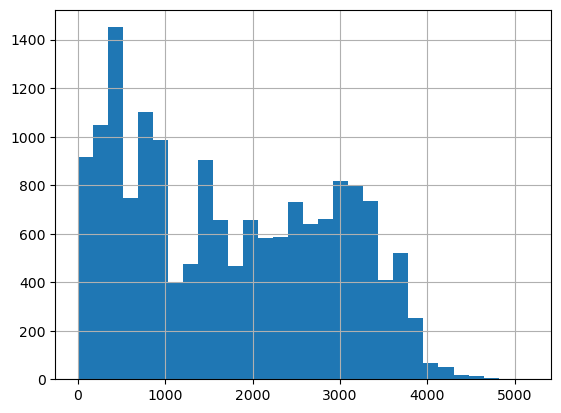

In [126]:
# distribution of neighbors
print(gdf_neighbors['num_neighbors'].le(1).sum())
print(gdf_neighbors['num_neighbors'].mean())
gdf_neighbors['num_neighbors'].hist(bins=30)

## S2: Explore

In [127]:
# see shape
df_competitors = gdf_neighbors.copy()
df_competitors['num_neighbors'].describe()

count    16697.000000
mean      1753.464095
std       1162.942969
min          1.000000
25%        692.000000
50%       1615.000000
75%       2797.000000
max       5157.000000
Name: num_neighbors, dtype: float64

In [128]:
# see shape
df_competitors.shape

(16697, 3)

In [132]:
# see shape vs original
gdf_work_comps.query("city_cluster.eq(19)").shape

(16703, 67)

In [133]:
# see competitors with only 1
df_competitors.sort_values(by='num_neighbors', ascending=False)

,observation_id_own,neighbors_list,num_neighbors
1557,c016a559-7526-4116-bd08-7069f1d0f878,"[(77ab9953-629a-4aa0-95be-783d2f81a7e6, 0.4722...",5157
623,4be8a94d-a65b-4a08-bd41-54d78158dd01,"[(77ab9953-629a-4aa0-95be-783d2f81a7e6, 0.4879...",4858
1956,f08d8dcf-d21b-4b4a-9fb7-628eb1e19525,"[(77ab9953-629a-4aa0-95be-783d2f81a7e6, 0.4009...",4799
179,170987c1-e13c-4e2e-9cd9-7d69b872b3be,"[(77ab9953-629a-4aa0-95be-783d2f81a7e6, 0.4116...",4746
674,51c85748-2eab-4235-b74b-565ba1579cdc,"[(77ab9953-629a-4aa0-95be-783d2f81a7e6, 0.2664...",4657
...,...,...,...
78,0a310400-5801-4992-ba9b-150006714b69,"[(242a999c-8579-41b9-a5ea-cd0d0c5e9132, 0.0471...",2
838,696c44b4-12df-4e24-8c5f-7db26ae89a4b,"[(6dc73616-79ed-4a13-b5c2-37ed199c2eb3, 0.1920...",1
1156,8c6bc649-aef4-4e2c-b7b0-a9f68f8e4ba0,"[(6c623100-291f-48d7-a2f0-7bb187e2ed8c, 0.1382...",1
548,42152d20-0642-4a15-a4dd-1d1d9fa85484,"[(b3b33195-3343-4334-93ac-5624b3d3c583, 0.3403...",1


In [151]:
# expand and separate

(
    df_competitors
    .query("observation_id_own.eq('c016a559-7526-4116-bd08-7069f1d0f878')", engine='python')
    .explode('neighbors_list')
    .assign(
        observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
        total_distance=lambda x: x['neighbors_list'].str[1],
    )
    .drop(columns=['neighbors_list'])
    .sort_values(by='total_distance', ignore_index=True)
    # merge info of property_own
    .merge(
        gdf_properties.loc[:, cols_to_stay_comps],
        how='inner',
        left_on='observation_id_own',
        right_on='observation_id'
    )
    .drop(columns=['observation_id'])
    # merge info of property_neighbor
    .merge(
        gdf_properties.loc[:, cols_to_stay_comps],
        how='inner',
        left_on='observation_id_neighbor',
        right_on='observation_id',
        suffixes=('_own', '_neighbor'),
    )
    # sort columns by name
    .sort_index(axis=1)
)

,age_in_months_neighbor,age_in_months_own,bedrooms_cat_neighbor,bedrooms_cat_own,built_area_neighbor,built_area_own,conservation_status_id_recat_neighbor,conservation_status_id_recat_own,elevator_service_id_cat_neighbor,elevator_service_id_cat_own,full_bathrooms_cat_neighbor,full_bathrooms_cat_own,half_bathrooms_cat_neighbor,half_bathrooms_cat_own,land_area_neighbor,land_area_own,latitude_neighbor,latitude_own,longitude_neighbor,longitude_own,max_total_levels_recat_neighbor,max_total_levels_recat_own,num_neighbors,observation_id,observation_id_neighbor,observation_id_own,parking_lots_cat_neighbor,parking_lots_cat_own,property_class_id_cat_neighbor,property_class_id_cat_own,total_distance,valuation_date_neighbor,valuation_date_own
0,84,84,2,2,48.470001,48.25,4.0,4.0,0,0,1,1,1,1,48.470001,54.450001,1.099373e+06,1.099319e+06,4.056765e+06,4.056699e+06,2,2,5157,4be8a94d-a65b-4a08-bd41-54d78158dd01,4be8a94d-a65b-4a08-bd41-54d78158dd01,c016a559-7526-4116-bd08-7069f1d0f878,1,1,1,1,0.022717,2020-11-19,2021-01-26
1,84,84,2,2,48.009998,48.25,4.0,4.0,0,0,1,1,1,1,48.009998,54.450001,1.099341e+06,1.099319e+06,4.056733e+06,4.056699e+06,2,2,5157,ffb3cc42-8051-438f-b0b9-00221f412e85,ffb3cc42-8051-438f-b0b9-00221f412e85,c016a559-7526-4116-bd08-7069f1d0f878,1,1,1,1,0.041215,2021-09-23,2021-01-26
2,84,84,2,2,48.470001,48.25,4.0,4.0,0,0,1,1,1,1,48.470001,54.450001,1.099377e+06,1.099319e+06,4.056803e+06,4.056699e+06,2,2,5157,c3fce7a1-7df3-4fa7-b7ec-58ae3995448a,c3fce7a1-7df3-4fa7-b7ec-58ae3995448a,c016a559-7526-4116-bd08-7069f1d0f878,1,1,1,1,0.058859,2021-11-24,2021-01-26
3,36,84,2,2,69.370003,48.25,4.0,4.0,0,0,1,1,1,1,69.370003,54.450001,1.099306e+06,1.099319e+06,4.056673e+06,4.056699e+06,2,2,5157,8f4020fc-e771-4d4f-a762-e79d0a0bdca5,8f4020fc-e771-4d4f-a762-e79d0a0bdca5,c016a559-7526-4116-bd08-7069f1d0f878,0,1,1,1,0.069290,2021-06-24,2021-01-26
4,36,84,2,2,70.559998,48.25,4.0,4.0,0,0,1,1,1,1,70.559998,54.450001,1.099311e+06,1.099319e+06,4.056664e+06,4.056699e+06,2,2,5157,dd7b37af-25f1-4ffe-a599-c5c740b7800f,dd7b37af-25f1-4ffe-a599-c5c740b7800f,c016a559-7526-4116-bd08-7069f1d0f878,0,1,1,1,0.071138,2021-06-24,2021-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5152,0,84,2,2,44.459999,48.25,6.0,4.0,0,0,1,1,1,1,51.240002,54.450001,1.096927e+06,1.099319e+06,4.056114e+06,4.056699e+06,3,2,5157,42a2ba80-e195-471c-ba46-cbacfff90276,42a2ba80-e195-471c-ba46-cbacfff90276,c016a559-7526-4116-bd08-7069f1d0f878,1,1,1,1,0.536454,2022-12-07,2021-01-26
5153,0,84,2,2,44.209999,48.25,6.0,4.0,0,0,1,1,1,1,51.240002,54.450001,1.096929e+06,1.099319e+06,4.056099e+06,4.056699e+06,3,2,5157,660a427f-018a-48af-b8aa-ff7b3427af42,660a427f-018a-48af-b8aa-ff7b3427af42,c016a559-7526-4116-bd08-7069f1d0f878,1,1,1,1,0.536730,2022-12-07,2021-01-26
5154,0,84,2,2,47.320000,48.25,6.0,4.0,0,0,1,1,1,1,33.070000,54.450001,1.101075e+06,1.099319e+06,4.054931e+06,4.056699e+06,2,2,5157,303e56d5-8068-44da-941f-735039b06e3d,303e56d5-8068-44da-941f-735039b06e3d,c016a559-7526-4116-bd08-7069f1d0f878,0,1,1,1,0.538539,2022-09-26,2021-01-26
5155,0,84,2,2,44.209999,48.25,6.0,4.0,0,0,1,1,1,1,44.209999,54.450001,1.096983e+06,1.099319e+06,4.056084e+06,4.056699e+06,3,2,5157,9488e5d0-a18f-4af4-8bea-2beb3632f4f5,9488e5d0-a18f-4af4-8bea-2beb3632f4f5,c016a559-7526-4116-bd08-7069f1d0f878,1,1,1,1,0.539575,2023-01-13,2021-01-26


## S3: Create Sparse Matrix

In [ ]:
# create df that maps observation_id with index
df_properties_map = (
    gdf_properties
    .loc[:, ['observation_id']]
    .reset_index()
    .rename(columns={'index': 'property_index'})
)
df_properties_map

In [ ]:
# create function to map observation_id to index
def create_sparse_matrix_in_batches(df, df_indexes, batch_size=1_000):
    """
    Convert a large DataFrame with property IDs and neighbor distances into a sparse matrix in batches.

    Parameters:
    df (pd.DataFrame): DataFrame with 'observation_id_own' and 'neighbors_list' columns.
                       'observation_id_own' contains item IDs.
                       'neighbors_list' contains lists of tuples (neighbor_id, distance).
    df_indexes (pd.DataFrame): DataFrame with 'observation_id' and 'property_index' columns.
                                 'observation_id' contains item IDs.
                                    'property_index' contains item indices.
    batch_size (int): The number of rows to process in each batch.

    Returns:
    scipy.sparse.csr_matrix: The resulting sparse matrix.
    """
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize lists
    # info
    row_list = []
    col_list = []
    data_list = []

    # garantize the sparse matrix is square
    max_id = df_indexes['property_index'].max()

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with index map
        exploded_chunk_ids = (
            exploded_chunk
            # property id
            .merge(df_indexes, left_on='observation_id_own', right_on='observation_id')
            .loc[:, ['property_index', 'neighbors_list']]
            # neighbor id
            .assign(
                observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(df_indexes, left_on='observation_id_neighbor', right_on='observation_id', suffixes=('_own', '_neighbor'))
            .loc[:, ['property_index_own', 'property_index_neighbor', 'total_distance']]
        )

        # Extract row indices, column indices, and data values
        rows = exploded_chunk_ids['property_index_own'].values
        cols = exploded_chunk_ids['property_index_neighbor'].values
        distances = exploded_chunk_ids['total_distance'].values

        # Append to lists
        row_list.append(rows)
        col_list.append(cols)
        data_list.append(distances)

    # Concatenate all chunks
    rows = np.concatenate(row_list)
    cols = np.concatenate(col_list)
    distances = np.concatenate(data_list)

    # Create the sparse matrix, garanting it is square
    sparse_matrix = sp.csr_matrix((distances, (rows, cols)), shape=(max_id + 1, max_id + 1))

    return sparse_matrix

# Example usage
sparse_matrix_comps = create_sparse_matrix_in_batches(
    df=df_competitors,
    df_indexes=df_properties_map,
    batch_size=10_000
    )

print(sparse_matrix_comps.shape)

In [ ]:
# see shape
sparse_matrix_comps.shape

In [ ]:
# see how many non-zero elements
print(f"Non-zero elements: {sparse_matrix_comps.nnz}")
print(f"Sparsity: {sparse_matrix_comps.nnz / (sparse_matrix_comps.shape[0] * sparse_matrix_comps.shape[1])}")

In [ ]:
# how much memory it uses in MB
print(f"Memory usage: {sparse_matrix_comps.data.nbytes / 1e+6:.2f} MB")

## S4: Save

In [ ]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to pickle (in order to save lists, because parquet doesnt support lists)
df_competitors.to_pickle(f"{dir_save}/df_competitors.pkl")

In [ ]:
# save sparse matrix
sp.save_npz(f"{dir_save}/sparse_matrix_competitors.npz", sparse_matrix_comps)

In [ ]:
# save in matlab format
io.savemat(f"{dir_save}/sparse_matrix_competitors.mat", {"sparse_matrix_competitors": sparse_matrix_comps})

---
# Competitors Statistics

## S1: Define statistics

In [153]:
# summary statistics of competitors
def competitors_stats(df, col_to_summarize, xi=0.2):
    # get normalized weights
    weights_unorm = np.exp(-xi * df['total_distance'])
    weights = weights_unorm / weights_unorm.sum()
    n_neighbors = df.shape[0]
    sq_sum_weights = np.sum(weights**2) if n_neighbors > 1 else np.nan

    # get col to summarize
    x_array = df[col_to_summarize].values

    # weighted mean
    w_mean = np.sum(x_array * weights)

    return pd.Series({
        'weighted_mean': w_mean,
        'weighted_std': np.sqrt(
            # unbiased weighted std (theorem)
            (1 / (1 - sq_sum_weights)) * np.sum(weights * (x_array - w_mean)**2)
            ),
        'mean': np.mean(x_array),
        'std': np.std(x_array),
        'num_neighbors': n_neighbors,
    })


def get_info_from_competitors(df, df_info, col_to_summarize, xi=0.2, batch_size=2_000):
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize list
    df_competitors_info_list = []

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with info
        exploded_chunk = (
            exploded_chunk
            # neighbor id
            .assign(
                observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(
                df_info.loc[:, ['observation_id'] + [col_to_summarize]],
                left_on='observation_id_neighbor', right_on='observation_id',
                suffixes=('_own', '_neighbor')
            )
            .drop(columns=['observation_id', 'neighbors_list'])
        )

        # get stats
        df_competitors_info = (
            exploded_chunk
            .groupby('observation_id_own', as_index=False)
            .apply(
                competitors_stats,
                col_to_summarize=col_to_summarize,
                xi=xi,
                include_groups=False
                )
        )

        # append
        df_competitors_info_list.append(df_competitors_info)

    # concatenate
    df_competitors_info = pd.concat(df_competitors_info_list)

    return df_competitors_info

In [156]:
# get info from competitors
df_competitors_info = get_info_from_competitors(
    df=df_competitors,
    df_info=gdf_properties,
    col_to_summarize='log_price_per_sqm',
    xi=5,
    batch_size=1_000
    )
df_competitors_info

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Batches: 100%|██████████| 16/16 [02:21<00:00,  8.83s/it]


,observation_id_own,weighted_mean,weighted_std,mean,std,num_neighbors
0,000bd874-beb1-4479-89ab-21fbb178a206,9.458786,0.205239,9.454107,0.209664,3122.0
1,004b59b3-4a19-4e97-a251-8f9e4a59ba1f,9.372475,0.208981,9.395838,0.211475,2422.0
2,00749b03-e9fc-4ff0-bd70-c972116cf2f0,9.565384,0.186255,9.515875,0.192599,2117.0
3,007afd92-f712-4535-9667-48c705b1a106,9.554517,0.192038,9.508216,0.200219,2070.0
4,007e4b55-787c-4102-86e6-1f368b824ed6,9.806123,0.374891,9.853290,0.389547,506.0
...,...,...,...,...,...,...
1038,ff6b2532-2656-41f8-898d-f47ba94ac604,9.104485,0.043980,9.109334,0.049796,407.0
1039,ff77931d-e1d1-44b7-95e1-49a43d9d6050,9.558616,0.161860,9.525629,0.184325,1504.0
1040,ff87cdb7-0bd4-4321-89d9-ede9bec3a31a,9.164353,0.161238,9.168862,0.176673,1571.0
1041,ff90160c-cd9f-4705-a560-9881f8387d08,9.636204,0.173301,9.597338,0.175715,1310.0


In [157]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'weighted_mean': 'competitors_weighted_mean_log_price_per_sqm',
    'weighted_std': 'competitors_weighted_std_log_price_per_sqm',
    'mean': 'competitors_mean_log_price_per_sqm',
    'std': 'competitors_std_log_price_per_sqm',
    'num_neighbors': 'num_competitors',
})
df_competitors_info.head()

,observation_id_own,competitors_weighted_mean_log_price_per_sqm,competitors_weighted_std_log_price_per_sqm,competitors_mean_log_price_per_sqm,competitors_std_log_price_per_sqm,num_competitors
0,000bd874-beb1-4479-89ab-21fbb178a206,9.458786,0.205239,9.454107,0.209664,3122.0
1,004b59b3-4a19-4e97-a251-8f9e4a59ba1f,9.372475,0.208981,9.395838,0.211475,2422.0
2,00749b03-e9fc-4ff0-bd70-c972116cf2f0,9.565384,0.186255,9.515875,0.192599,2117.0
3,007afd92-f712-4535-9667-48c705b1a106,9.554517,0.192038,9.508216,0.200219,2070.0
4,007e4b55-787c-4102-86e6-1f368b824ed6,9.806123,0.374891,9.853290,0.389547,506.0


## S2: EDA

In [158]:
# merge with original data
gdf_work_comps = (
    gdf_work_comps
    .merge(
        df_competitors_info,
        how='left',
        left_on='observation_id',
        right_on='observation_id_own',
    )
    .drop(columns=['observation_id_own'])
)

# shape
gdf_work_comps.shape

(16703, 72)

In [159]:
# see how many properties have competitors
gdf_work_comps['num_competitors'].describe()

count    16697.000000
mean      1753.464095
std       1162.942969
min          1.000000
25%        692.000000
50%       1615.000000
75%       2797.000000
max       5157.000000
Name: num_competitors, dtype: float64

<Axes: xlabel='log_price_per_sqm', ylabel='competitors_weighted_mean_log_price_per_sqm'>

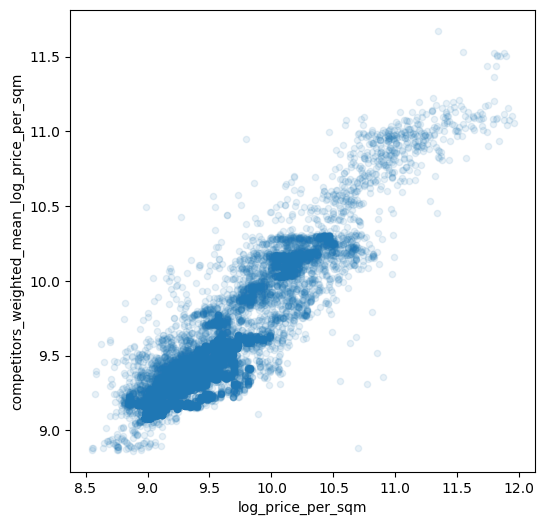

In [160]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_work_comps
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_weighted_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

<Axes: xlabel='log_price_per_sqm', ylabel='competitors_mean_log_price_per_sqm'>

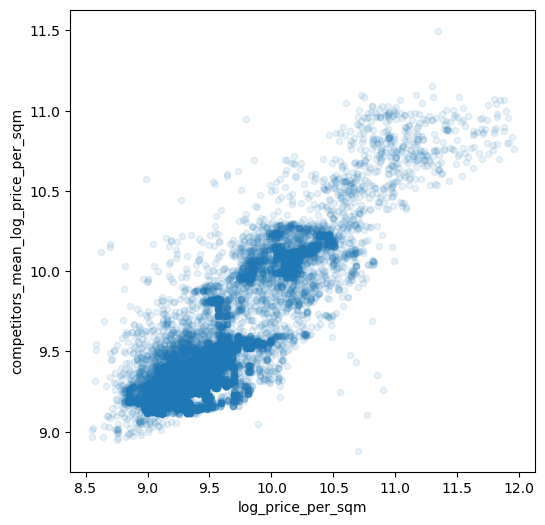

In [161]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_work_comps
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

In [163]:
# see corr between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm and competitors_mean_log_price_per_sqm
(
    gdf_work_comps
    .query("num_competitors.ge(4)")
    .loc[:, ['log_price_per_sqm', 'competitors_weighted_mean_log_price_per_sqm', 'competitors_mean_log_price_per_sqm']]
    .corr(method='pearson')
)

,log_price_per_sqm,competitors_weighted_mean_log_price_per_sqm,competitors_mean_log_price_per_sqm
log_price_per_sqm,1.000000,0.920815,0.875092
competitors_weighted_mean_log_price_per_sqm,0.920815,1.000000,0.988458
competitors_mean_log_price_per_sqm,0.875092,0.988458,1.000000


In [164]:
# error using comps
gdf_work_comps['error_comps'] = 1 - np.exp(gdf_work_comps['competitors_weighted_mean_log_price_per_sqm'] - gdf_work_comps['log_price_per_sqm'])

# using non weighted mean
gdf_work_comps['error_comps_mean'] = 1 - np.exp(gdf_work_comps['competitors_mean_log_price_per_sqm'] - gdf_work_comps['log_price_per_sqm'])


# see error

In [172]:
print(gdf_work_comps['error_comps'].describe())

count    16697.000000
mean        -0.016697
std          0.199821
min         -5.216487
25%         -0.112833
50%         -0.014783
75%          0.099476
max          0.836460
Name: error_comps, dtype: float64


In [173]:
print(gdf_work_comps['error_comps_mean'].describe())

count    16697.000000
mean        -0.023018
std          0.246880
min         -5.216487
25%         -0.161936
50%         -0.013787
75%          0.137853
max          0.836550
Name: error_comps_mean, dtype: float64


count    16697.000000
mean         0.139423
std          0.144109
min          0.000009
25%          0.047694
50%          0.106596
75%          0.188362
max          5.216487
Name: error_comps, dtype: float64


<Axes: >

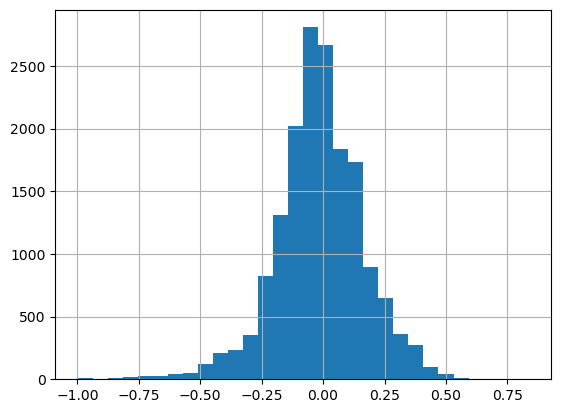

In [170]:
# see error
print(gdf_work_comps['error_comps'].abs().describe())

# see distribution of error
gdf_work_comps.query("error_comps.abs().le(1)")['error_comps'].hist(bins=30)

count    16697.000000
mean         0.177192
std          0.173438
min          0.000060
25%          0.065880
50%          0.148036
75%          0.236538
max          5.216487
Name: error_comps_mean, dtype: float64


<Axes: >

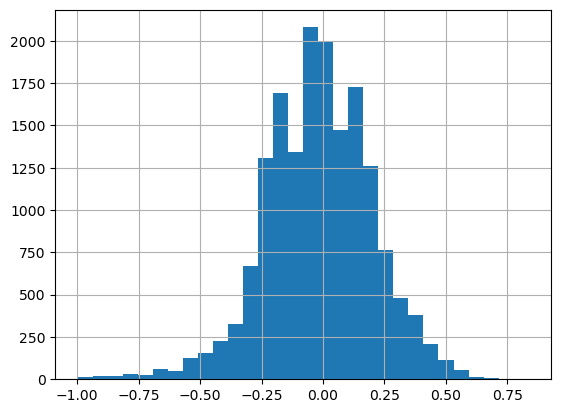

In [171]:
# see error
print(gdf_work_comps['error_comps_mean'].abs().describe())

# see distribution of error
gdf_work_comps.query("error_comps_mean.abs().le(1)")['error_comps_mean'].hist(bins=30)

## S3: Save

In [ ]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'observation_id_own': 'observation_id'
})
df_competitors_info.head()

In [ ]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to parquet
df_competitors_info.to_parquet(f"{dir_save}/df_competitors_stats.parquet")

---
# Save

In [ ]:
df_competitors_info.drop(columns='observation_id').columns

In [ ]:
# drop competitors columns
gdf_properties.drop(columns=df_competitors_info.drop(columns='observation_id').columns, inplace=True)

# sort index
gdf_properties = gdf_properties.sort_index()

# save to parquet
gdf_properties.to_parquet("../../data/interim/cleaned_data_s6.parquet")

---
# Sandbox

In [ ]:
gdf_neighbors_subset_distance

In [ ]:
gdf_work_comps.info()

In [ ]:
gdf_properties['property_class_id'].value_counts()

In [ ]:
gdf_properties.filter(like='conservation').value_counts()

In [ ]:
gdf_properties['age_in_months'].describe()

In [ ]:
gdf_properties.filter(like='area')

In [ ]:
# plot level vs total_levels, facet grid by property_type
g = sns.FacetGrid(gdf_properties, col="property_type_id", height=6)

g.map(
    sns.scatterplot,
    "level",
    "total_levels",
    alpha=1
)

In [ ]:
# histogram of max levels
gdf_properties[['level', 'total_levels']].max(axis=1).plot(kind='hist', bins=100)

In [ ]:
# histogram of max levels
gdf_properties[['level', 'total_levels']].max(axis=1)

In [106]:
# neighborhood that are similar to ROMA NORTE
mask = gdf_work_comps['neighborhood'].str.contains("HEROES", case=False, na=False)
gdf_work_comps[mask]

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,geometry,property_type,price_per_sqm,log_price_per_sqm,bedrooms_cat,full_bathrooms_cat,half_bathrooms_cat,property_class_id_cat,conservation_status_id_recat,max_total_levels,max_total_levels_recat,elevator_service_id_cat,parking_lots_cat,neighbors_list
